In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Importing the data

In [12]:
raw_data = pd.read_csv('Index2018.csv')
raw_data.head()
# market indexes

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Transform raw data into Time-Series Data

In [18]:
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace = True)
df = df.asfreq('b') # 'b' - business days
df.fillna(method = 'ffill', inplace = True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [19]:
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Using Returns

In [32]:
# create returns out of prices
# returns = (p(t) - p(t-1)) / p(t-1)
df['ftse_returns'] = df.ftse.pct_change(1).mul(100)
df.head()

,spx,dax,ftse,nikkei,ftse_returns
date,,,,,
1994-01-10,475.27,2225.00,3440.58,18443.44,NaN
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166
1994-01-14,474.91,2151.05,3400.56,18973.70,1.206842


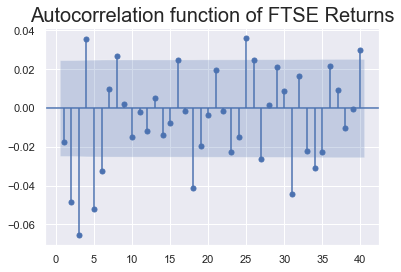

In [30]:
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(df.ftse_returns.iloc[1:], lags = 40, zero = False)
plt.title('Autocorrelation function of FTSE Returns', size = 20)
plt.show()

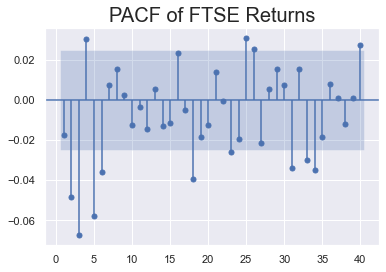

In [31]:
sgt.plot_pacf(df.ftse_returns.iloc[1:], lags = 40, zero = False, alpha = 0.05, method = ('ols'))
plt.title('PACF of FTSE Returns', size = 20)
plt.show()

## Log Likelihood Ratio (LLR) Test

In [37]:
from scipy.stats.distributions import chi2

def LLR_test(model_1, model_2, DF = 1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    
    LR = 2*(L2 - L1)
    p = chi2.sf(LR, DF).round(3)
    
    return p

## MA(1) model for Returns

In [34]:
from statsmodels.tsa.arima.model import ARIMA

ma_1 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 1))
results_ma_1 = ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -9596.554
Date:                Wed, 16 Nov 2022   AIC                          19199.107
Time:                        23:54:26   BIC                          19219.340
Sample:                    01-11-1994   HQIC                         19206.118
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.014      1.357      0.175      -0.008       0.046
ma.L1         -0.0196      0.007     -2.612      0.009      -0.034      -0.005
sigma2         1.2471      0.011    113.216      0.000       1.225       1.269
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10487.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag MA Models

In [46]:
ma_2 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 2))
results_ma_2 = ma_2.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_1, ma_2)))
print(results_ma_2.summary())

LLR test p-value: 0.0


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -9588.784
Date:                Thu, 17 Nov 2022   AIC                          19185.569
Time:                        00:03:49   BIC                          19212.546
Sample:                    01-11-1994   HQIC                         19194.916
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.420      0.156      -0.007       0.045
ma.L1         -0.0254      0.008     -3.337      0.001      -0.040      -0.010
ma.L2         -0.0488      0

In [47]:
ma_3 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 3))
results_ma_3 = ma_3.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_2, ma_3)))
print(results_ma_3.summary())

LLR test p-value: 0.0


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -9572.439
Date:                Thu, 17 Nov 2022   AIC                          19154.877
Time:                        00:07:53   BIC                          19188.599
Sample:                    01-11-1994   HQIC                         19166.561
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.013      1.502      0.133      -0.006       0.044
ma.L1         -0.0175      0.008     -2.298      0.022      -0.032      -0.003
ma.L2         -0.0539      0

In [48]:
ma_4 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 4))
results_ma_4 = ma_4.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_3, ma_4)))
print(results_ma_4.summary())

LLR test p-value: 0.013


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -9569.355
Date:                Thu, 17 Nov 2022   AIC                          19150.709
Time:                        00:09:54   BIC                          19191.175
Sample:                    01-11-1994   HQIC                         19164.730
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.013      1.454      0.146      -0.007       0.045
ma.L1         -0.0169      0.008     -2.151      0.032      -0.032      -0.002
ma.L2         -0.0540     

In [49]:
ma_5 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 5))
results_ma_5 = ma_5.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_4, ma_5)))
print(results_ma_5.summary())

LLR test p-value: 0.0


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -9561.590
Date:                Thu, 17 Nov 2022   AIC                          19137.179
Time:                        00:10:06   BIC                          19184.390
Sample:                    01-11-1994   HQIC                         19153.537
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.013      1.512      0.131      -0.006       0.044
ma.L1         -0.0214      0.008     -2.657      0.008      -0.037      -0.006
ma.L2         -0.0494      0

In [50]:
ma_6 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 6))
results_ma_6 = ma_6.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_5, ma_6)))
print(results_ma_6.summary())

LLR test p-value: 0.019


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -9558.836
Date:                Thu, 17 Nov 2022   AIC                          19133.672
Time:                        00:10:19   BIC                          19187.626
Sample:                    01-11-1994   HQIC                         19152.366
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.012      1.545      0.122      -0.005       0.043
ma.L1         -0.0195      0.008     -2.413      0.016      -0.035      -0.004
ma.L2         -0.0487     

In [51]:
ma_7 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 7))
results_ma_7 = ma_7.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_6, ma_7)))
print(results_ma_7.summary())

LLR test p-value: 0.552


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -9558.659
Date:                Thu, 17 Nov 2022   AIC                          19135.318
Time:                        00:10:38   BIC                          19196.017
Sample:                    01-11-1994   HQIC                         19156.350
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.012      1.528      0.127      -0.005       0.044
ma.L1         -0.0201      0.008     -2.475      0.013      -0.036      -0.004
ma.L2         -0.0491     

In [52]:
# see ACF plot:
# the 7th value is not significant but the 8th is!
# this is why we continue to increase number of lags in the model
# there is a huge chance that we can get a better model

ma_8 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 8))
results_ma_8 = ma_8.fit()
print("LLR test p-value: {}\n\n".format(LLR_test(ma_7, ma_8)))
print(results_ma_8.summary())

LLR test p-value: 0.04


                               SARIMAX Results                                
Dep. Variable:           ftse_returns   No. Observations:                 6275
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -9556.558
Date:                Thu, 17 Nov 2022   AIC                          19133.115
Time:                        00:13:38   BIC                          19200.558
Sample:                    01-11-1994   HQIC                         19156.483
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.013      1.484      0.138      -0.006       0.044
ma.L1         -0.0198      0.008     -2.408      0.016      -0.036      -0.004
ma.L2         -0.0492      

In [55]:
# MA(8) > MA(7) - p-value = 0.04
# but MA(7) < MA(6)
# MA(8) > MA(6) - ?

print("LLR test p-value: {}".format(LLR_test(ma_6, ma_8, DF = 2)))
# Using 5% significance we can conclude that MA(6) is better then MA(8)

LLR test p-value: 0.102


## Residuals for Returns

In [68]:
df['ftse_returns_residuals'] = results_ma_6.resid[1:]
df.head()

,spx,dax,ftse,nikkei,ftse_returns,ftse_returns_residuals
date,,,,,,
1994-01-10,475.27,2225.00,3440.58,18443.44,NaN,NaN
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229,NaN
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988,-1.255786
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166,-0.434485
1994-01-14,474.91,2151.05,3400.56,18973.70,1.206842,1.068632


In [69]:
print("Mean: {}, \nvariance: {}, \nstd: {}".format(round(df.ftse_returns_residuals.mean(), 3),
                                                   round(df.ftse_returns_residuals.var(), 3), 
                                                   round(df.ftse_returns_residuals.std(), 3)))

Mean: 0.0, 
variance: 1.232, 
std: 1.11


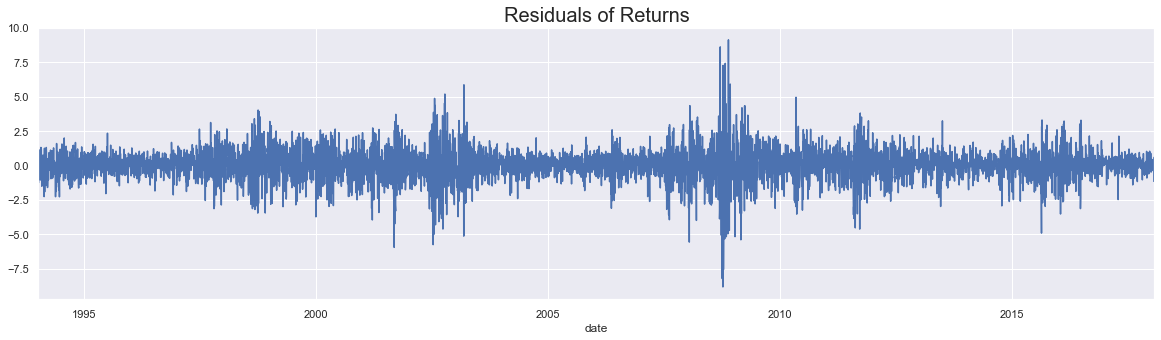

In [70]:
df.ftse_returns_residuals.iloc[1:].plot(figsize = (20, 5))
plt.title('Residuals of Returns', size = 20)
plt.show()

In [71]:
sts.adfuller(df.ftse_returns_residuals.iloc[2:]) # p-value ~ 0

(-14.929107279859418,
 1.3748282829085766e-27,
 34,
 6239,
 {'1%': -3.43139856427888,
  '5%': -2.8620033722813014,
  '10%': -2.567016650141434},
 19019.662124080714)

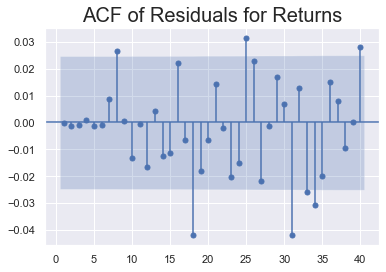

In [72]:
sgt.plot_acf(df.ftse_returns_residuals.iloc[2:], lags = 40, zero = False)
plt.title('ACF of Residuals for Returns', size = 20)
plt.show()